In [22]:
import matplotlib.pyplot as plt
import pickle

In [2]:
file='logs2022-05-14_11:36:01'
with open('out/'+file+'.pkl','rb') as savefile:
    save = pickle.load(savefile)

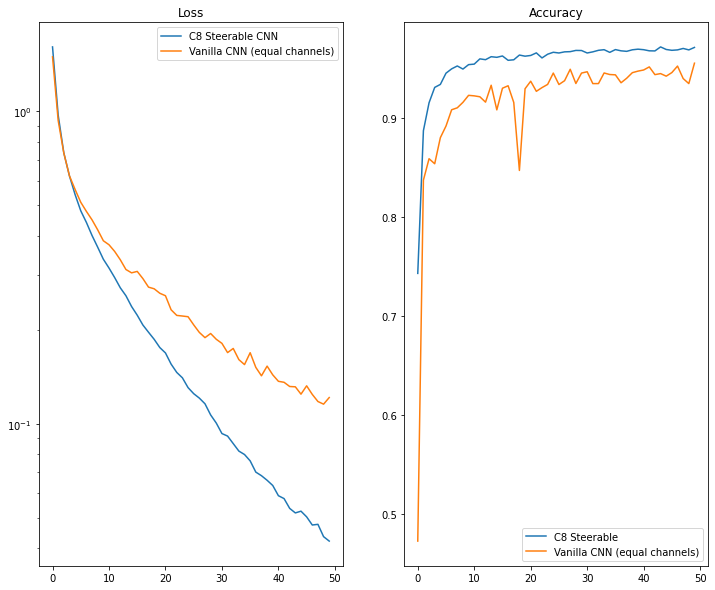

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
ax1.plot(save['steerable']['train']['loss'], label='C8 Steerable CNN')
ax1.plot(save['unsteerable']['train']['loss'], label='Vanilla CNN (equal channels)')
ax1.legend()
ax1.set_title('Loss')
ax1.set_yscale('log')
ax2.plot(save['steerable']['validation']['accuracy'], label='C8 Steerable')
ax2.plot(save['unsteerable']['validation']['accuracy'], label='Vanilla CNN (equal channels)')
ax2.legend()
ax2.set_title('Accuracy')
plt.show()
#plt.savefig('out/'+file+'.png')

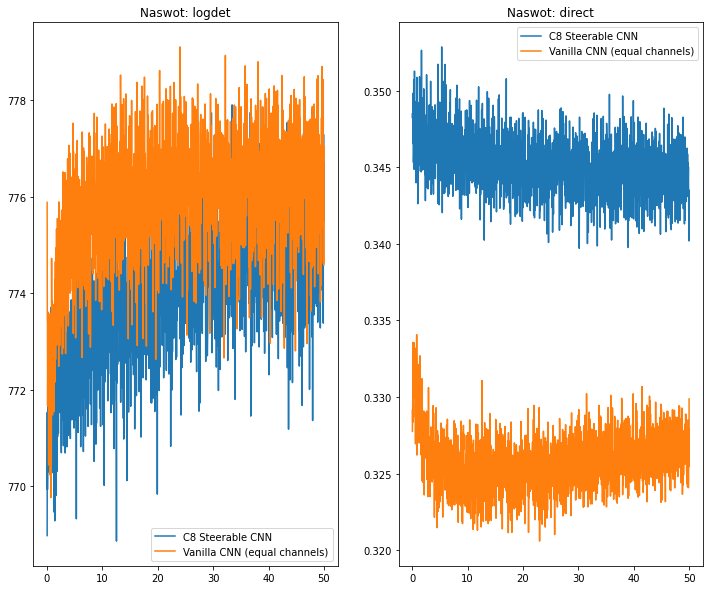

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
flatbatch = [item for sublist in save['steerable']['train']['batch'] for item in sublist]
if not max(flatbatch) > 1.0:
    epoch = 0
    for (i, batch) in enumerate(flatbatch):
        flatbatch[i] += epoch
        if batch == 1.0:
            epoch += 1
indices = [i+1 for i in range(len(flatbatch)-1) if flatbatch[i+1]-flatbatch[i] > 0.02]
ax1.plot([flatbatch[i] for i in indices], [save['steerable']['train']["naswot_ld"][i] for i in indices], label='C8 Steerable CNN')
ax1.plot([flatbatch[i] for i in indices], [save['unsteerable']['train']["naswot_ld"][i] for i in indices], label='Vanilla CNN (equal channels)')
ax1.legend()
ax1.set_title('NASWOT: logdet')
ax2.plot(flatbatch, save['steerable']['train']["naswot_rs"], label='C8 Steerable CNN')
ax2.plot(flatbatch, save['unsteerable']['train']["naswot_rs"], label='Vanilla CNN (equal channels)')
ax2.legend()
ax2.set_title('NASWOT: direct')
plt.show()
#plt.savefig('out/'+file+'testbatch.png')

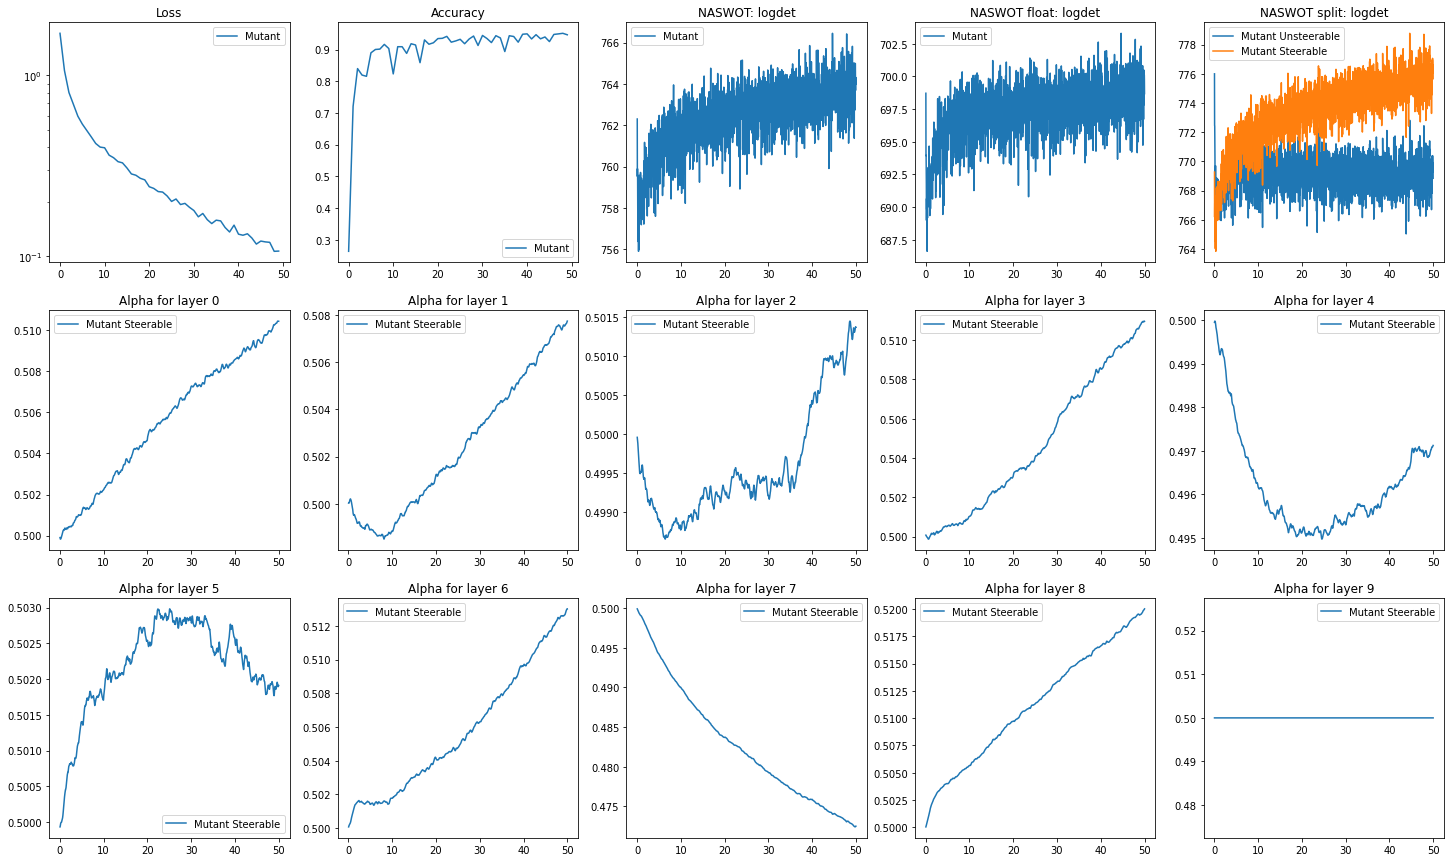

In [28]:
file='logsmutant2022-05-17_15:11:29'
with open('out/'+file+'.pkl','rb') as savefile:
    logs_mutant = pickle.load(savefile)
logs_mutant = logs_mutant["mutant"]
fig, ax = plt.subplots(3, 5, figsize=(25,15))
flatbatch = [item for sublist in logs_mutant['train']['batch'] for item in sublist]
if not max(flatbatch) > 1.0:
    epoch = 0
    for (i, batch) in enumerate(flatbatch):
        flatbatch[i] += epoch
        if batch == 1.0:
            epoch += 1
indices = [i+1 for i in range(len(flatbatch)-1) if flatbatch[i+1]-flatbatch[i] > 0.02]
ax[0,0].plot(logs_mutant['train']['loss'], label='Mutant')
ax[0,0].legend()
ax[0,0].set_title('Loss')
ax[0,0].set_yscale('log')
ax[0,1].plot(logs_mutant['validation']['accuracy'], label='Mutant')
ax[0,1].legend()
ax[0,1].set_title('Accuracy')
ax[0,2].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ld"][i] for i in indices], label='Mutant')
ax[0,2].legend()
ax[0,2].set_title('NASWOT: logdet')
ax[0,3].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldF"][i] for i in indices], label='Mutant')
ax[0,3].legend()
ax[0,3].set_title('NASWOT float: logdet')
ax[0,4].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldU"][i] for i in indices], label='Mutant Unsteerable')
ax[0,4].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldS"][i] for i in indices], label='Mutant Steerable')
ax[0,4].legend()
ax[0,4].set_title('NASWOT split: logdet')
for l in range(10):
    ax[int(l/5)+1,l%5].plot([flatbatch[i] for i in indices], [logs_mutant['train']["alphas"][l][i] for i in indices], label='Mutant Steerable')
    ax[int(l/5)+1,l%5].legend()
    ax[int(l/5)+1,l%5].set_title('Alpha for layer '+str(l))
